#Apresentando os Dados de Entrada

In [1]:
import os
import imageio.v3 as imageio

#Obtendo os dados de entrada
dataset_folder = "images/"
files = os.listdir(dataset_folder)
files.sort()
print(files)

['chest_xray_1.png', 'chest_xray_2.png', 'chest_xray_3.png', 'chest_xray_4.png', 'chest_xray_5.png', 'chest_xray_6.png', 'references', 'result', 'skin_lesion_1.jpg', 'skin_lesion_2.jpg', 'skin_lesion_3.jpg', 'skin_lesion_4.jpg', 'skin_lesion_5.jpg', 'skin_lesion_6.jpg']


In [2]:
#Carregando as imagens em uma lista
images = []
for I_file in files:
  if I_file == 'references' or I_file == 'result':
    continue
  I  = imageio.imread(dataset_folder+I_file) #Carrega a Imagem de Entrada
  images.append(I)

In [3]:
dataset_folder = "images/references/"
files = os.listdir(dataset_folder)

output_filenames = []
for filename in files:
  output_filenames.append(dataset_folder + filename)
output_filenames.sort()
print(output_filenames)

['images/references/chest_xray_1_ref-case1.png', 'images/references/chest_xray_2_ref-case2.png', 'images/references/chest_xray_3_ref-case3.png', 'images/references/chest_xray_4_ref-case4.png', 'images/references/chest_xray_5_ref-case5.png', 'images/references/chest_xray_6_ref-case6.png', 'images/references/skin_lesion_1_ref-case7.png', 'images/references/skin_lesion_2_ref-case8.png', 'images/references/skin_lesion_3_ref-case9.png', 'images/references/skin_lesion_4_ref-case10.png', 'images/references/skin_lesion_5_ref-case11.png', 'images/references/skin_lesion_6_ref-case12.png']


In [4]:
import matplotlib.pyplot as plt

def show_images(data, rows=2, columns=5, figsize=(10, 4)):
    fig, axes = plt.subplots(figsize=figsize, nrows=rows, ncols=columns, dpi=150)

    for i in range(rows):
      for j in range(columns):
        ax = axes[i, j]
        idx = i*columns+j
        ax.imshow(data[idx], cmap="gray")
        curr_label = f"Image {idx}"
        ax.title.set_text(curr_label)
        ax.axis('off')
    plt.show()

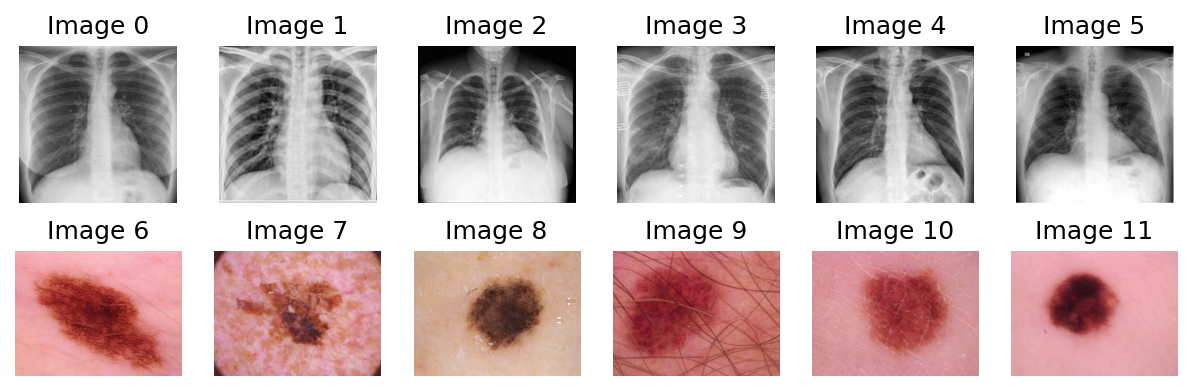

In [5]:
#Apresentando as imagens de entrada
show_images(images, rows=2, columns=6, figsize=(10, 3))

#Conversão para Grayscale

In [6]:
import numpy as np

#Transforma as imagem para escala de cinza
images_gray = []

for img in images:
  if len(img.shape) > 2: #Se for RGB converte para Gray, senão apenas mantém
    img = np.dot(img, [0.2989, 0.5870, 0.1140]).astype(np.int64)
  images_gray.append(img)

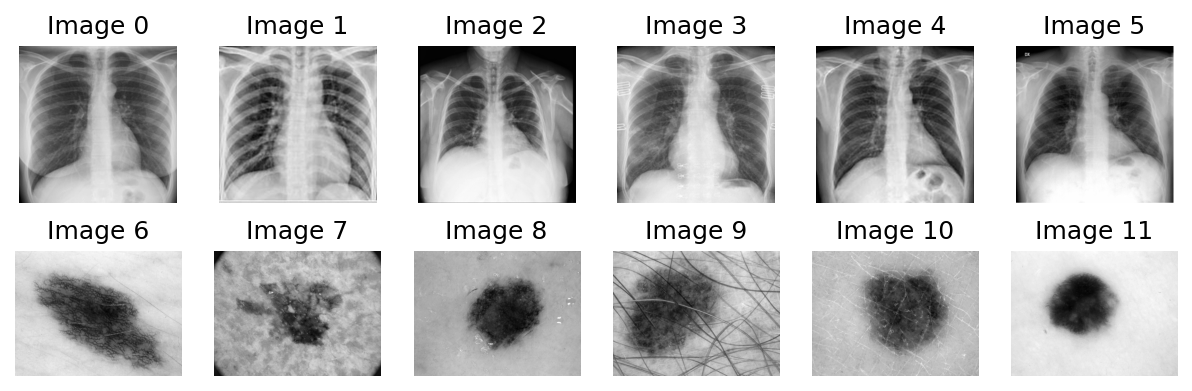

In [7]:
#Apresentando as imagens de entrada (Em Grayscale)
show_images(images_gray, rows=2, columns=6, figsize=(10, 3))

#Limiarização Adaptativa (Otsu)

In [8]:
def otsu_threshold(img, th_max=256):
    total_pixels = img.size

    best_th = None
    min_sigma = np.inf
    
    for th in range(1, th_max):
        # Create the thresholded image
        thresholded_im = np.zeros_like(img)
        thresholded_im[img >= th] = 1
        
        # Compute weights
        count_pixels_1 = np.count_nonzero(thresholded_im)
        w_b = count_pixels_1 / total_pixels
        w_a = 1 - w_b

        # If one of the classes is empty >> threshold not considered
        if (w_b == 0) or (w_a == 0):
            continue

        # Find all pixels belonging to each class
        class_0_pixels = img[thresholded_im == 0]
        class_1_pixels = img[thresholded_im == 1]

        # Variance of each class
        sig_a = np.var(class_0_pixels) if len(class_0_pixels) > 0 else 0 # if to avoid warnings and errors
        sig_b = np.var(class_1_pixels) if len(class_1_pixels) > 0 else 0

        # Calculate Otsu sigma
        sigma = ((w_a * sig_a) + (w_b * sig_b))

        if sigma < min_sigma:
            min_sigma = sigma
            best_th = th

    # Binarize the image based on the best threshold
    binary_img = np.where(img > best_th, 255, 0)

    return binary_img

In [9]:
#Transforma as imagem em binárias
images_bin = []

for img in images_gray:
  new_img = otsu_threshold(img.copy())
  images_bin.append(new_img)

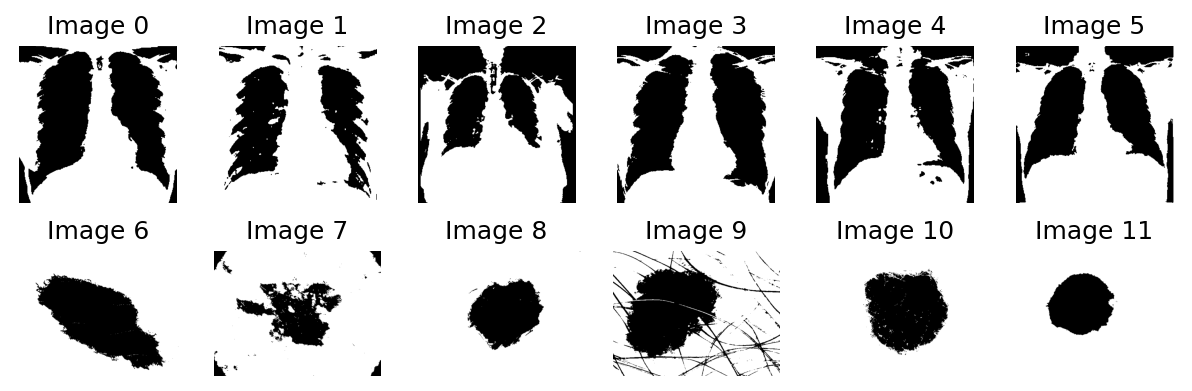

In [10]:
#Apresentando as imagens de entrada (Em Grayscale)
show_images(images_bin, rows=2, columns=6, figsize=(10, 3))

#Aplicando Processamento Morfológico (Erosão e Dilatação)

In [11]:
"""Retorna a imagem erodita"""
def erosion(img, M, N):
    # Define the 3x3 kernel for erosion
    kernel = np.ones((3,3))
    
    # Create an empty image to store the result
    img_ers = np.zeros((M,N))
    
    # Padding the image
    img_pad = np.pad(img, pad_width=1)
    
    # Iterate over each pixel in the image
    for y in range(1, M-1):
        for x in range(1, N-1):
            # Extract the 3x3 neighborhood around the current pixel
            neighborhood = img_pad[y-1:y+2, x-1:x+2]
            
            # Apply erosion operation using the kernel
            img_ers[y, x] = np.min(neighborhood * kernel)
    
    return img_ers

"""Retorna a imagem dilatada"""
def dilation(img, M, N):
    # Define the 3x3 kernel for erosion
    kernel = np.ones((3,3))
    
    # Create an empty image to store the result
    img_dil = np.zeros((M,N))
    
    # Padding the image
    img_pad = np.pad(img, pad_width=1)
    
    # Iterate over each pixel in the image
    for y in range(1, M-1):
        for x in range(1, N-1):
            # Extract the 3x3 neighborhood around the current pixel
            neighborhood = img_pad[y-1:y+2, x-1:x+2]
            
            # Apply dilation operation using the kernel
            img_dil[y, x] = np.max(neighborhood * kernel)
    
    return img_dil

In [12]:
# from skimage import morphology

# def erosion(img, M, N):
#   S = morphology.square(3)
#   img_er = morphology.binary_erosion(img, S).astype(np.uint8)
#   return img_er

# def dilation(img, M, N):
#   S = morphology.square(3)
#   img_dil = morphology.binary_dilation(img, S).astype(np.uint8)
#   return img_dil

In [13]:
#Define o conjunto de operações a serem realizadas para cada imagem individualmente
#Onde 1=Erosão e 2=Dilatação
ciclo_morfologico = [[2,2,2,2,2,2,2,2,2,1,1,1], #Image 0
                     [1,1,1,2,2,2,2,1], #Image 1
                     [2,2,2,2,1], #Image 2
                     [2,2,1,1], #Image 3
                     [2,2,1,1,2,2,1], #Image 4
                     [2,2,2,2,2,2,1,1,1], #Image 5
                     [1,1,2,2,1], #Image 6
                     [1,1,1,1,1,1,1,2,2,2,2,2,2,2], #Image 7
                     [1,1,2,2,2], #Image 8
                     [2,2,2,2,1,1,1,1,1], #Image 9
                     [1,1,2,2], #Image 10
                     [1,1,2,2]] #Image 11

#Transforma as imagem com Operações Morfológicas
images_morf = []
for idx,img in enumerate(images_bin):
  M, N = img.shape
  for apply_morphology in ciclo_morfologico[idx]:
    if apply_morphology == 1:
      #Ciclo de Erosões (Expande a área de interesse PRETA e Reduz a BRANCA -> Voltar ao tamanho original sem ruído)
      img = erosion(img, M, N)
    elif apply_morphology == 2:
      #Ciclo de Dilatações (Expande a área de NÃO interesse BRANCA e Reduz a PRETA -> Redução de ruído)
      img = dilation(img, M, N)
  images_morf.append(img)

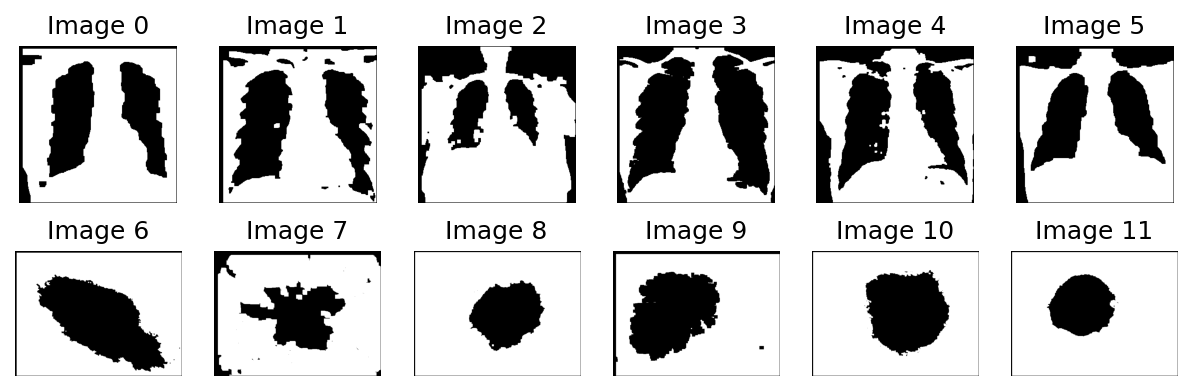

In [14]:
#Apresentando as imagens de entrada (Em Grayscale)
show_images(images_morf, rows=2, columns=6, figsize=(10, 3))

#Aplicando Cor em Regiões de Interesse (Heatmap)
## **Você poderá utilizar as funções a seguir na sua implementação.**

In [15]:
def filter_gaussian(P, Q):
    s1 = P
    s2 = Q

    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            x = (u-(P/2))**2/(2*s1**2) + (v-(Q/2))**2/(2*s2**2)
            D[u, v] = np.exp(-x)
    return D

In [16]:
#Espectro Visível
heatmap_colors = [
    [1, 0, 1],   # Pink
    [0, 0, 1],   # Blue
    [0, 1, 0],   # Green
    [1, 1, 0],   # Yellow
    [1, 0, 0]    # Red
]

# Function to map values to colors
def map_value_to_color(value, min_val, max_val, colormap):
    # Scale the value to the range [0, len(colormap) - 1]
    scaled_value = (value - min_val) / (max_val - min_val) * (len(colormap) - 1)
    # Determine the two closest colors in the colormap
    idx1 = int(scaled_value)
    idx2 = min(idx1 + 1, len(colormap) - 1)
    # Interpolate between the two colors based on the fractional part
    frac = scaled_value - idx1
    color = [
        (1 - frac) * colormap[idx1][0] + frac * colormap[idx2][0],
        (1 - frac) * colormap[idx1][1] + frac * colormap[idx2][1],
        (1 - frac) * colormap[idx1][2] + frac * colormap[idx2][2]
    ]
    return color

In [17]:
"""Calcula o erro"""
def rms_error(img, out):
    M,N = img.shape
    error = ((1/(M*N))*np.sum((img-out)**2))**(1/2)
    return error

In [18]:
#Transforma as imagens FINAIS
images_out = []

# Define alpha value for blending
alpha = 0.30  # Adjust this value to control the transparency of the heatmap

for idx,img in enumerate(images_gray):
  #Obtendo a máscara binária
  mask = images_morf[idx]

  #Coloração Gradiente
  M, N = mask.shape[0], mask.shape[1]
  color_distribution = filter_gaussian(M, N)
  min_val = np.min(np.array(color_distribution))
  max_val = np.max(np.array(color_distribution))

  heatmap_image = np.zeros([M, N, 3]) #Imagem RGB vazia
  for i in range(M):
      for j in range(N):
          heatmap_image[i, j] = map_value_to_color(color_distribution[i, j], min_val, max_val, heatmap_colors)

  img_color = np.ones([M, N, 3]) #Imagem RGB vazia
  indexes = np.where(mask==0)
  img_color[indexes] = heatmap_image[indexes]

  #Imagem final
  gray_image = img
  gray_image_normalized = gray_image / np.max(gray_image)

  # Mix the grayscale image and heatmap using alpha compositing
  mixed_image = ((1 - alpha) * np.expand_dims(gray_image_normalized, axis=-1)) + ((alpha) * img_color)

  images_out.append(mixed_image)

  #Calcula o erro para cada canal de cor
  H = imageio.imread(output_filenames[idx]) #Carrega a Imagem de Referencia
  H_norm = H / np.max(H)

  error_R = rms_error(mixed_image[:,:,0], H_norm[:,:,0])
  error_G = rms_error(mixed_image[:,:,1], H_norm[:,:,1])
  error_B = rms_error(mixed_image[:,:,2], H_norm[:,:,2])
  error = (error_R + error_G + error_B)/3
  print(f"Index {idx}: {error:.4f}")

Index 0: 0.0878
Index 1: 0.0887
Index 2: 0.0597
Index 3: 0.0670
Index 4: 0.0805
Index 5: 0.0762
Index 6: 0.0447
Index 7: 0.0738
Index 8: 0.0388
Index 9: 0.0620
Index 10: 0.0376
Index 11: 0.0364


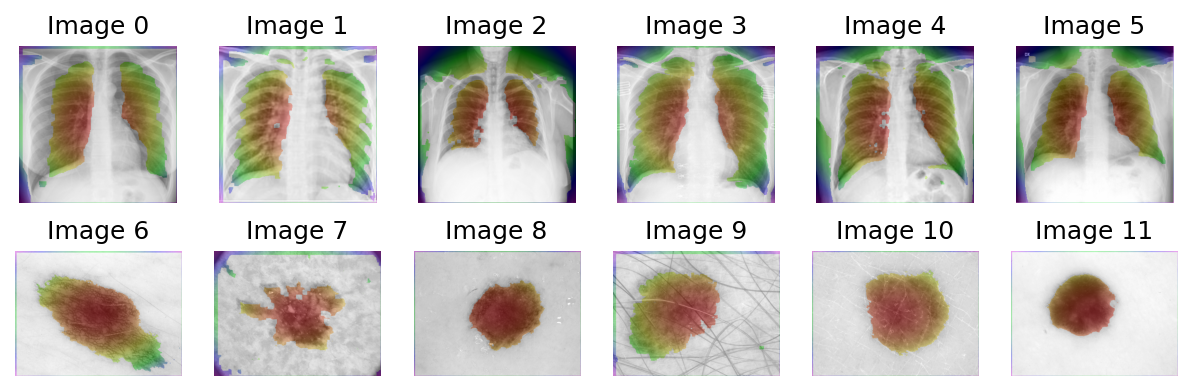

In [19]:
#Apresentando as imagens de Saída (Finais)
show_images(images_out, rows=2, columns=6, figsize=(10, 3))